In [67]:
%cd "F:/University/Master's Thesis/Datasets/BGL Data"

F:\University\Master's Thesis\Datasets


In [ ]:
%pip install pytorch-lightning
%pip install lightning

In [68]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [69]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

# Load BGL dataset into a DataFrame (Replace 'path_to_your_file' with the actual file path)
file_path = 'bgl_structured_data.csv'
df = pd.read_csv(file_path)
df.head(5)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1186991,-,1119695655,2005.06.25,R32-M0-NA-C:J14-U11,2005-06-25-03.34.15.417108,R32-M0-NA-C:J14-U11,RAS,KERNEL,INFO,254619084 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['254619084']
1,1186992,-,1119695655,2005.06.25,R32-M0-NA-C:J10-U11,2005-06-25-03.34.15.438456,R32-M0-NA-C:J10-U11,RAS,KERNEL,INFO,255442463 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['255442463']
2,1186993,-,1119695655,2005.06.25,R32-M0-NA-C:J10-U11,2005-06-25-03.34.15.451519,R32-M0-NA-C:J10-U11,RAS,KERNEL,INFO,256867576 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['256867576']
3,1186994,-,1119695655,2005.06.25,R32-M0-NA-C:J06-U11,2005-06-25-03.34.15.472919,R32-M0-NA-C:J06-U11,RAS,KERNEL,INFO,255099253 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['255099253']
4,1186995,-,1119695655,2005.06.25,R32-M0-NA-C:J06-U11,2005-06-25-03.34.15.486042,R32-M0-NA-C:J06-U11,RAS,KERNEL,INFO,258522516 double-hummer alignment exceptions,6265c739,<*> double-hummer alignment exceptions,['258522516']


In [70]:
df["Time"] = pd.to_datetime(df["Time"], format='%Y-%m-%d-%H.%M.%S.%f')

# Calculate time_idx for seconds
df["time_idx"] = (
    df["Time"].dt.year * 365 * 24 * 60 * 60 +  # Convert years to seconds
    df["Time"].dt.month * 30 * 24 * 60 * 60 +  # Convert months to seconds (assuming 30 days per month)
    df["Time"].dt.day * 24 * 60 * 60 +  # Convert days to seconds
    df["Time"].dt.hour * 60 * 60 +  # Convert hours to seconds
    df["Time"].dt.minute * 60 +  # Convert minutes to seconds
    df["Time"].dt.second  # Seconds
)

df = df.sort_values(by="time_idx")

# Removing duplicate time_idx values for only rows where time_idx and Node are same
df = df.drop_duplicates(subset=['time_idx', 'Node', 'EventId'], keep=False)


In [71]:
# Display the DataFrame with the new time_idx column
df[["Node", "Level", "time_idx", "Component", "EventTemplate"]].groupby('Node').head(100)

,Node,Level,time_idx,Component,EventTemplate
1644188,R02-M1-N0-C:J12-U11,INFO,63245547785,KERNEL,instruction cache parity error corrected
1644253,R02-M1-N0-C:J12-U11,INFO,63245547808,KERNEL,instruction cache parity error corrected
1644260,R02-M1-N0-C:J12-U11,INFO,63245547810,KERNEL,instruction cache parity error corrected
1644269,R02-M1-N0-C:J12-U11,INFO,63245547814,KERNEL,instruction cache parity error corrected
1644292,R02-M1-N0-C:J12-U11,INFO,63245547822,KERNEL,instruction cache parity error corrected
...,...,...,...,...,...
2356265,R37-M1-N0-C:J02-U11,INFO,63260901376,KERNEL,<*> microseconds spent in the rbs signal handl...
2356266,R51-M1-N0-C:J08-U11,INFO,63260901376,KERNEL,<*> total interrupts. <*> critical input inter...
2356267,R37-M0-N0-C:J05-U11,INFO,63260901376,KERNEL,<*> total interrupts. <*> critical input inter...
2356259,R10-M1-NC-C:J05-U01,INFO,63260901376,KERNEL,<*> total interrupts. <*> critical input inter...


In [72]:
unique_values = df['EventId'].unique()
print(len(unique_values))

516


In [73]:
df['Node'].fillna('-', inplace=True)

In [74]:
df['Node'] = df['Node'].astype('str')
df['Component'] = df['Component'].astype('str')
df['Level'] = df['Level'].astype('str')
df['EventId'] = df['EventId'].astype('str')
df['EventTemplate'] = df['EventTemplate'].astype('str')
df['Type'] = df['Type'].astype('str')

df['Node'] = df['Node'].astype('category')
df['Component'] = df['Component'].astype('category')
df['Level'] = df['Level'].astype('category')
df['EventId'] = df['EventId'].astype('category')
df['EventTemplate'] = df['EventTemplate'].astype('category')
df['Type'] = df['Type'].astype('category')

In [75]:
data_type = df['time_idx'].dtype
print("time_idx: " + str(data_type))

data_type = df['Node'].dtype
print("Node: " + str(data_type))

data_type = df['Component'].dtype
print("Component: " + str(data_type))

data_type = df['Level'].dtype
print("Level: " + str(data_type))

data_type = df['EventId'].dtype
print("EventId: " + str(data_type))

data_type = df['EventTemplate'].dtype
print("EventTemplate: " + str(data_type))

data_type = df['Type'].dtype
print("Type: " + str(data_type))

time_idx: int64
Node: category
Component: category
Level: category
EventId: category
EventTemplate: category
Type: category


In [76]:
# Replace 'Column_Name' with the name of the column you're interested in
empty_rows = df['Node'].isnull().sum()

print(f"Number of empty rows in 'Node': {empty_rows}")


Number of empty rows in 'Node': 0


In [77]:
df.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList,time_idx
1644188,237496,-,1117838585,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:05.980712,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],63245547785
1644253,237561,-,1117838608,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:28.948656,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],63245547808
1644260,237568,-,1117838610,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:30.008754,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],63245547810
1644269,237577,-,1117838614,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:34.978903,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],63245547814
1644292,237600,-,1117838622,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03 15:43:42.042890,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[],63245547822


In [78]:
top_lengths = df['Node'].value_counts().head(30)
print(top_lengths)

UNKNOWN_LOCATION       4607
R30-M0-N7-C:J09-U01    3912
R63-M0-N3-C:J02-U11    3816
R35-M0-N0-C:J07-U01    2972
R37-M1-NC-C:J02-U11    1824
R06-M1-N6-C:J15-U01    1812
R20-M1-NF-C:J10-U01    1618
R16-M1-N2-C:J17-U01    1555
R10-M0-N7-C:J17-U01    1518
R00-M1-NF-C:J13-U11    1246
R55-M0-N9-C:J06-U11    1217
R10-M1-N5-C:J04-U11     950
R07-M0-N6-C:J11-U01     898
R63-M1-NC-C:J06-U01     897
-                       801
R21-M0-ND-C:J04-U01     767
R15-M1-N6-C:J04-U11     731
R03-M1-NF-C:J07-U01     697
R23-M0-N8-C:J15-U11     689
R01-M0-N8-C:J02-U11     686
R22-M1-N3-C:J06-U01     671
R73-M1-N1-C:J16-U11     670
R32-M0-NF-C:J14-U01     658
R61-M1-ND-C:J07-U11     656
R03-M1-N9-C:J09-U11     654
R11-M1-N3-C:J07-U11     647
R32-M1-N9-C:J16-U11     647
R25-M1-ND-C:J09-U01     646
R16-M1-N2-C:J16-U11     645
R17-M0-N0-C:J10-U01     635
Name: Node, dtype: int64


In [79]:
#nodes_to_remove = ['R30-M0-N9-C:J16-U01', 'R02-M1-N0-C:J12-U11', "-", "UNKNOWN_LOCATION", "R16-M1-N2-C:J17-U01", "R26-M0-N0-I:J18-U11", "R02-M0-N4-C:J04-U11"]  # Example list of nodes to remove
nodes_to_remove = ["UNKNOWN_LOCATION", "-"]  # Example list of nodes to remove

# Removing rows where 'Node' column matches specified nodes
df = df[~df['Node'].isin(nodes_to_remove)]

In [80]:
total_rows = len(df)  # Retrieves the length of the DataFrame (number of rows)
print("Total number of rows:", total_rows)


Total number of rows: 2553869


In [81]:
from pytorch_forecasting.data import GroupNormalizer

# Define TimeSeriesDataSet
# Assuming columns 'Timestamp', 'Node', 'Content' as relevant features
max_encoder_length = 3920  # Define the length of the encoder sequence
max_prediction_length = 600  # Define the length of the prediction horizon
training_cutoff = df['time_idx'].max() - max_prediction_length

# Define the TimeSeriesDataSet
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="EventId",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_categoricals=["Component", "Level", "EventId"],  
    static_categoricals=["Node"],  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    )

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [82]:
training.get_parameters()

{'time_idx': 'time_idx',
 'target': 'EventId',
 'group_ids': ['Node'],
 'weight': None,
 'max_encoder_length': 3920,
 'min_encoder_length': 1960,
 'min_prediction_idx': 63245547785,
 'min_prediction_length': 1,
 'max_prediction_length': 600,
 'static_categoricals': ['Node'],
 'static_reals': ['encoder_length'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['relative_time_idx'],
 'time_varying_unknown_categoricals': ['Component', 'Level', 'EventId'],
 'time_varying_unknown_reals': [],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': NaNLabelEncoder(add_nan=False, warn=True),
 'categorical_encoders': {'__group_id__Node': NaNLabelEncoder(add_nan=False, warn=True),
  'Node': NaNLabelEncoder(add_nan=False, warn=True),
  'Component': NaNLabelEncoder(add_nan=False, warn=True),
  'Level': NaNLabelEncoder(add_

In [83]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(1.1902)

In [85]:
import tensorflow as tf
import tensorboard as tb

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 562.4k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 3.235936569296285
Restoring states from the checkpoint path at F:\University\Master's Thesis\Datasets\.lr_find_cb217f07-b47f-4aa9-b84f-5b6e7543073f.ckpt
Restored all states from the checkpoint at F:\University\Master's Thesis\Datasets\.lr_find_cb217f07-b47f-4aa9-b84f-5b6e7543073f.ckpt


suggested learning rate: 3.235936569296285


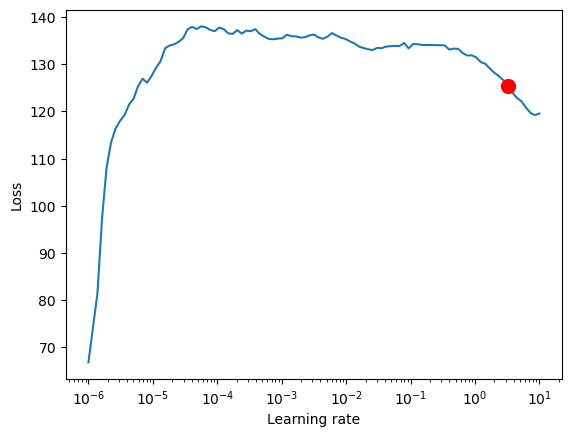

In [57]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [90]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=40,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 1130.3k


In [91]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.1 M 
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 654   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 952   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [92]:
# Choosing the best tft model from the checkpoints
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [93]:
# Saving the model to disk
import pickle

# save study results - also we can resume tuning at a later point in time
with open("tft_bgl_v3.pkl", "wb") as fout:
    pickle.dump(best_tft_model, fout)

In [94]:
import pickle

with open("tft_bgl_v3.pkl",'rb') as f:
    best_tft=pickle.load(f)
    

In [95]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: F:\University\Master's Thesis\Datasets\lightning_logs


tensor(32.2705)

In [96]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [97]:
raw_predictions.index.head(20)

,time_idx,Node
0,63260893781,R11-M0-N4-C:J02-U01
1,63252816318,R11-M1
2,63252816355,R11-M1-N7
3,63260894555,R21-M0-NA-C:J08-U11
4,63260894549,R21-M0-NF-C:J02-U01
5,63260894556,R21-M1-N7-C:J02-U11
6,63260844916,R22-M0-N1
7,63260844916,R22-M0-N3
8,63260844916,R22-M0-N4
9,63260844917,R22-M0-N5


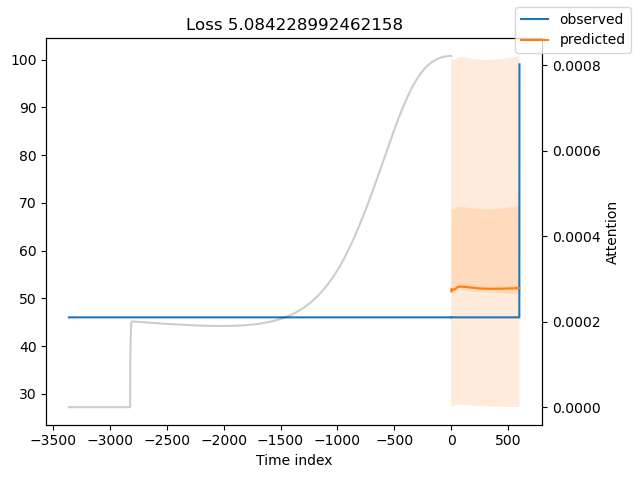

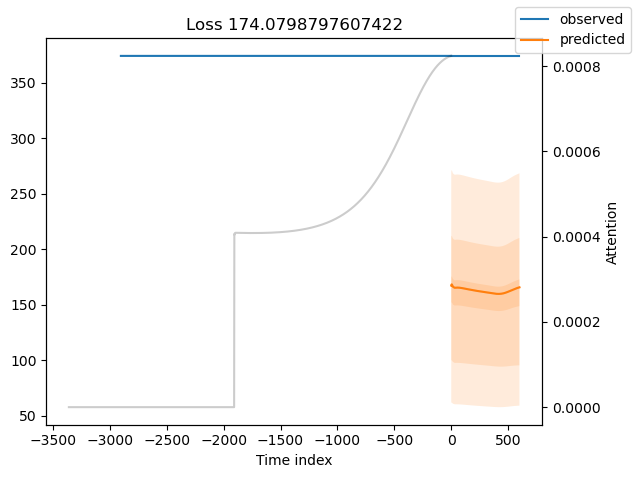

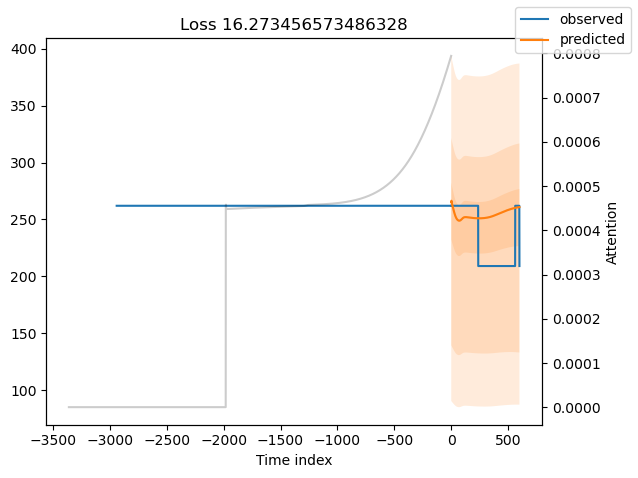

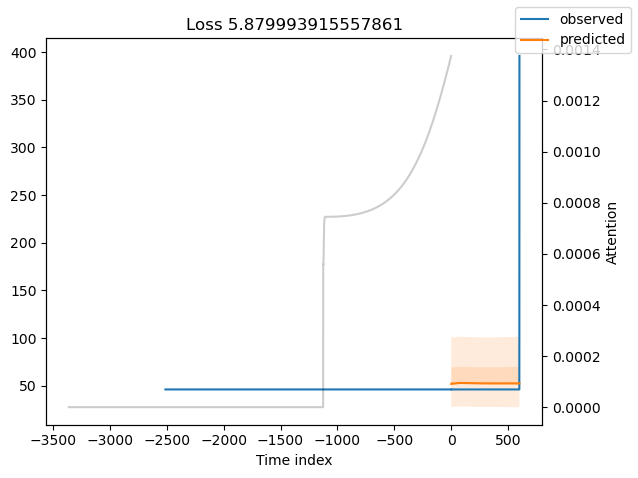

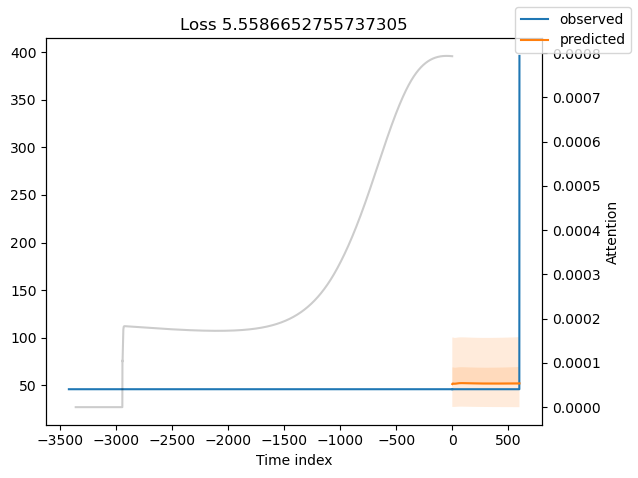

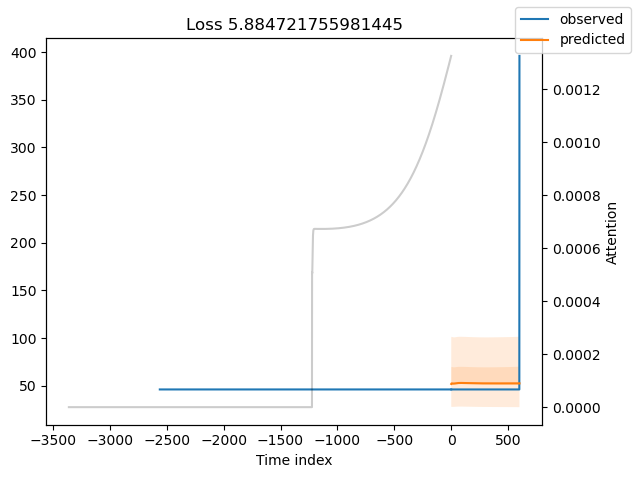

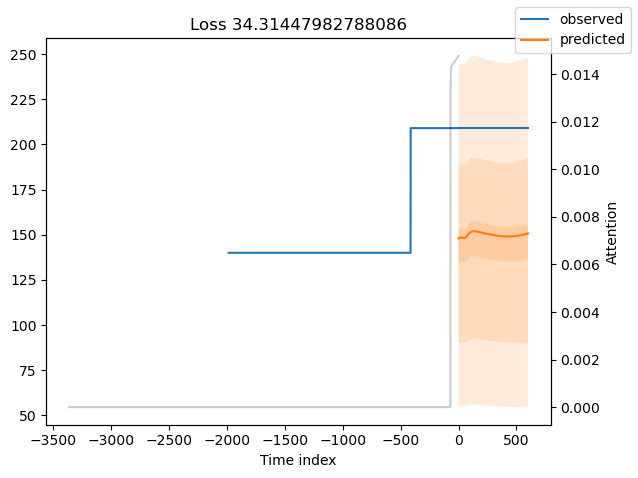

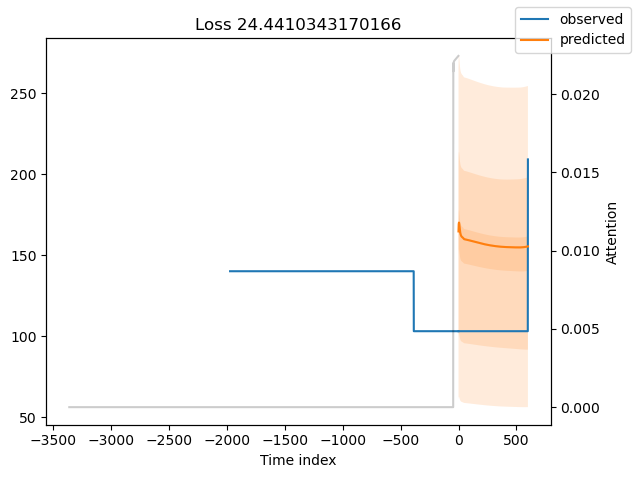

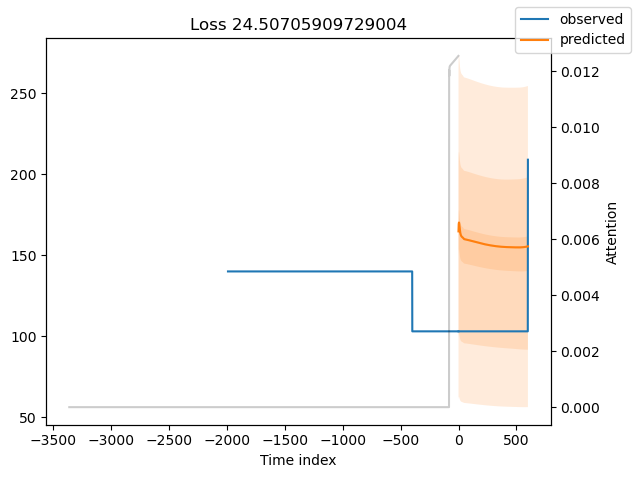

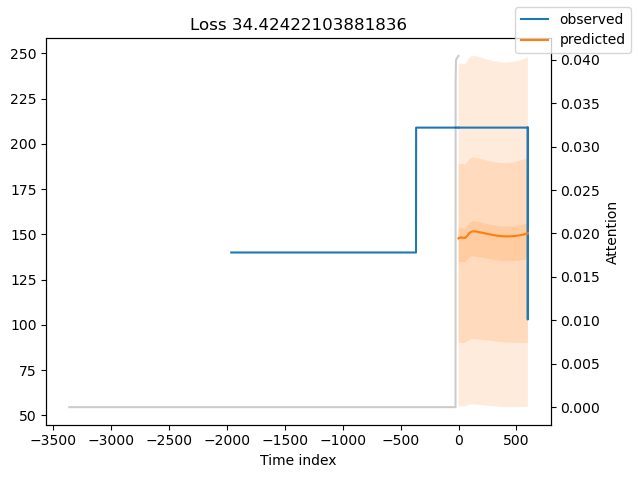

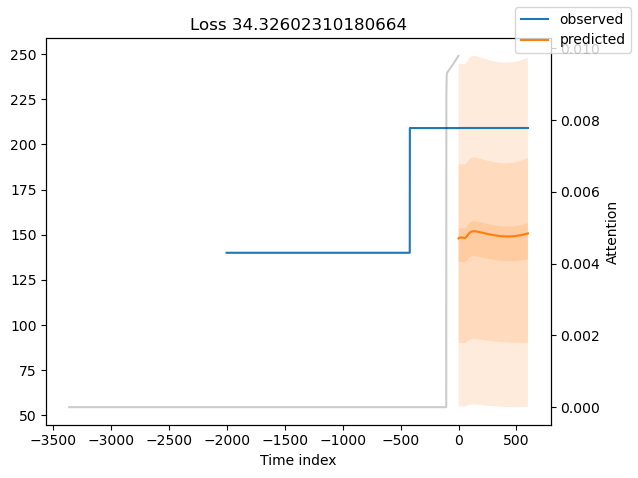

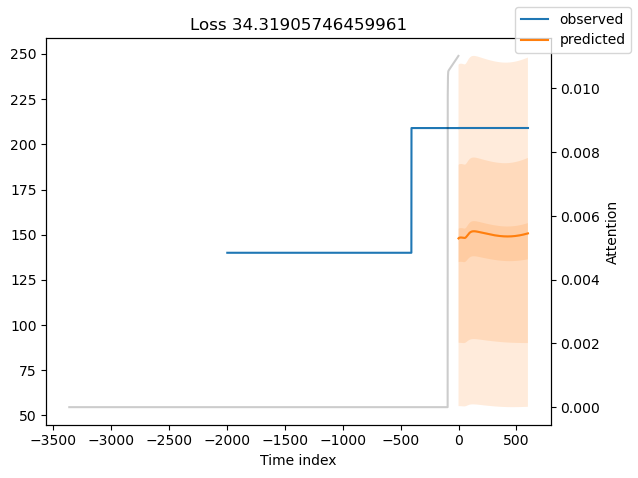

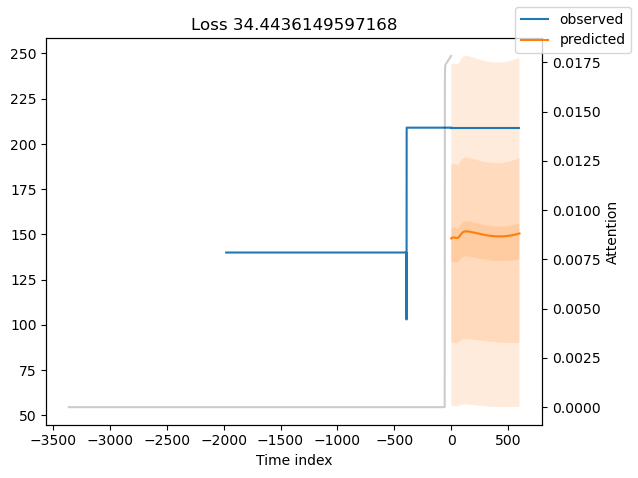

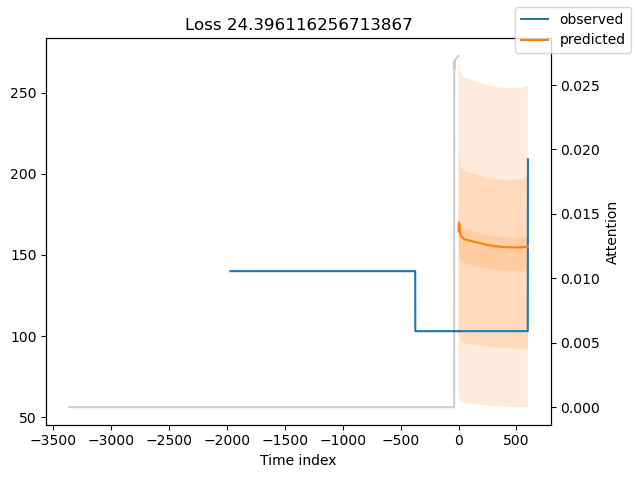

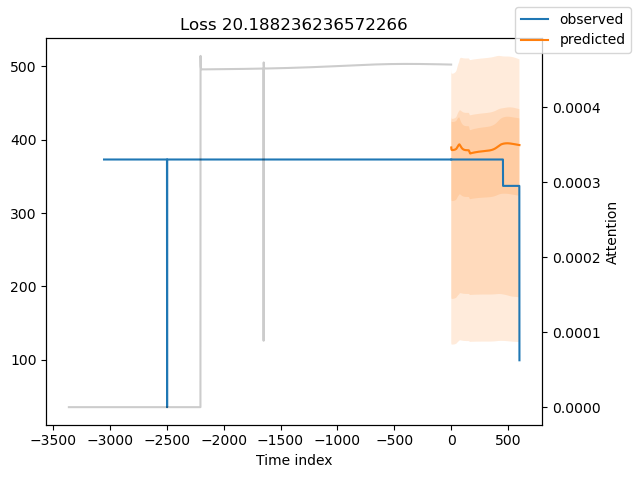

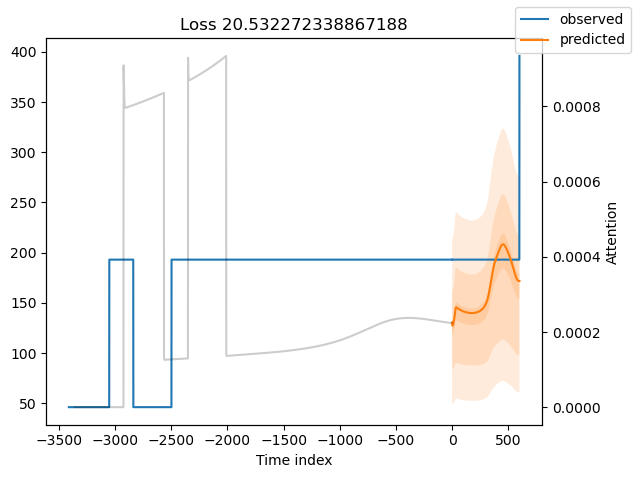

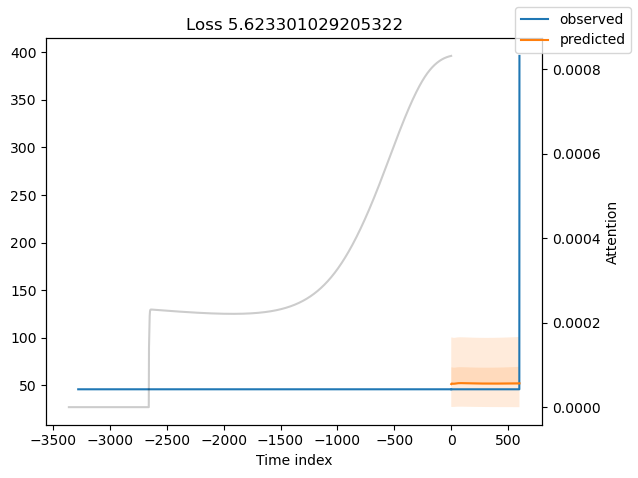

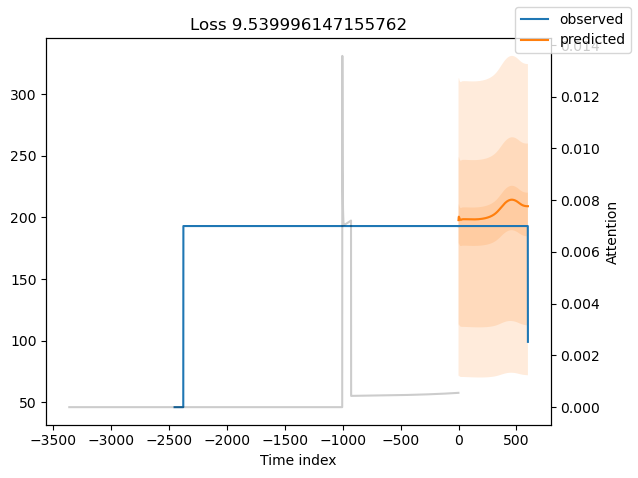

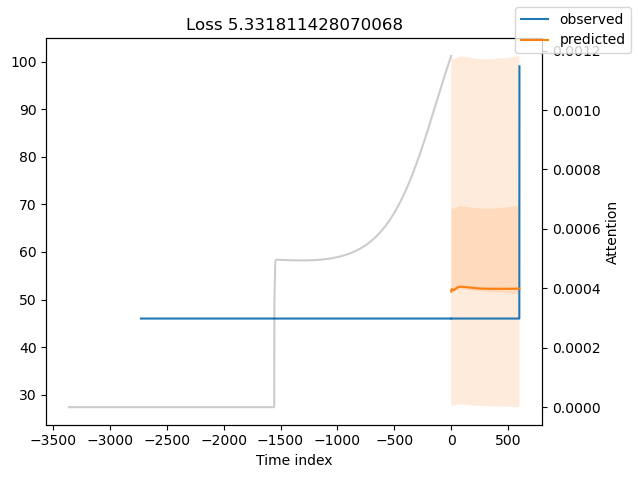

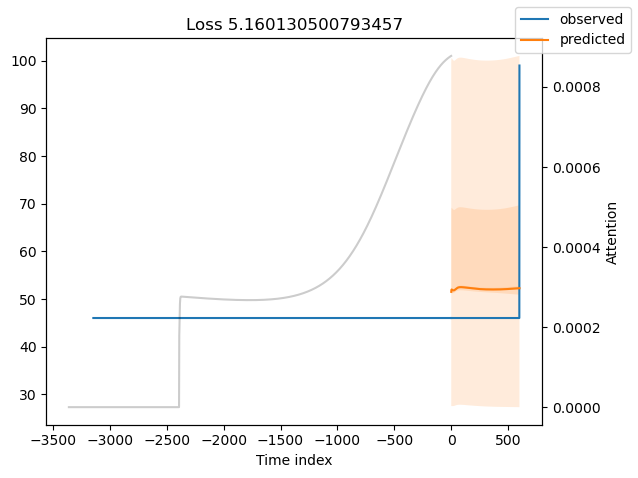

In [98]:
for idx in range(20):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

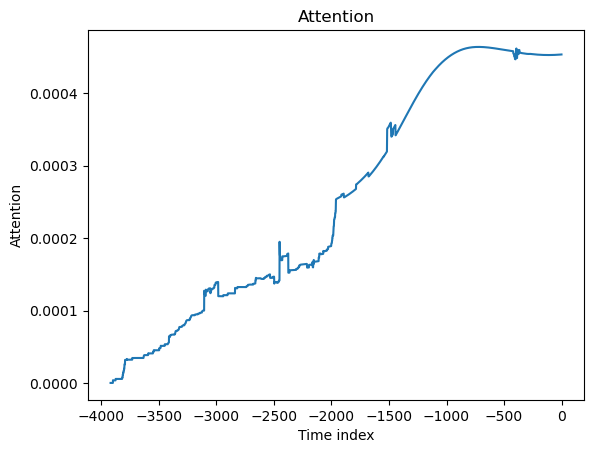

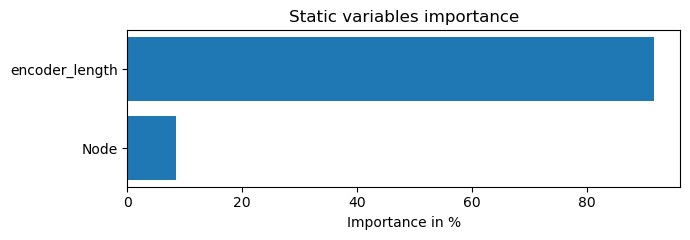

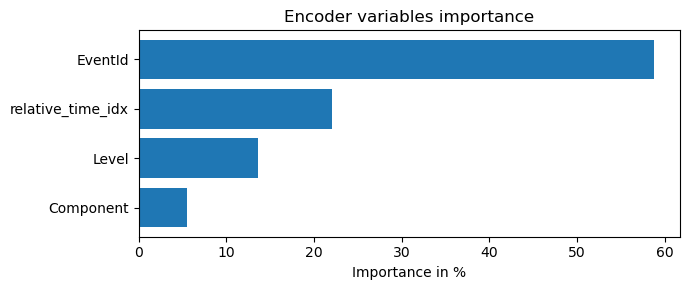

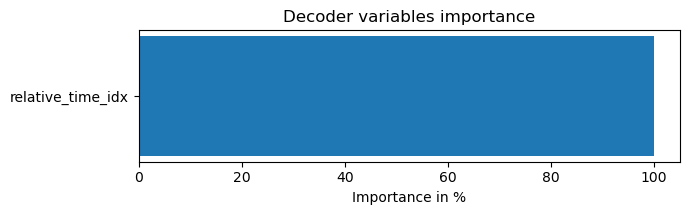

In [99]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [102]:
predictions = best_tft.predict(
    training.filter(lambda x: (x.Node == "R35-M0-N3-C:J03-U11")),
    mode="raw",return_y=True, return_index=True, return_decoder_lengths=True, return_x=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


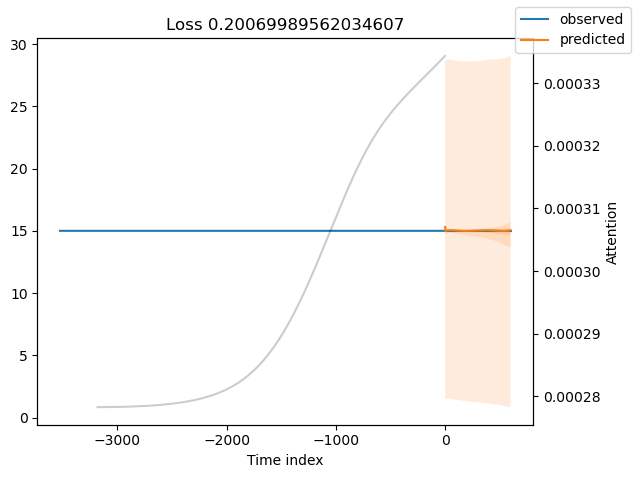

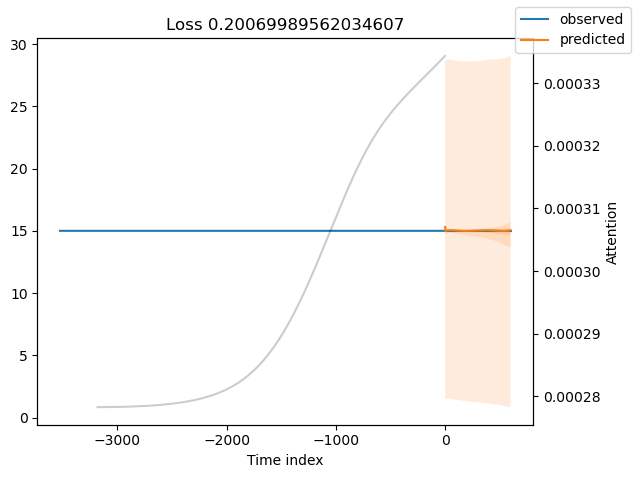

In [103]:
best_tft.plot_prediction(predictions.x, predictions.output, idx=1, add_loss_to_title=True)

In [104]:
for key, value in predictions.items():
    print(f"Field: {key}")
    if isinstance(value, torch.Tensor):
        print(f"Tensor shape: {value.shape}")
    else:
        print(f"Type: {type(value)}")

Field: output
Type: <class 'pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output'>
Field: x
Type: <class 'dict'>
Field: index
Type: <class 'pandas.core.frame.DataFrame'>
Field: decoder_lengths
Tensor shape: torch.Size([27])
Field: y
Type: <class 'tuple'>


In [107]:
# Assuming 'output' contains categorical predictions encoded with NaNLabelEncoder
decoded_output = training.target_normalizer.inverse_transform(predictions.output.argmax(dim=1).numpy())
print(decoded_output)

AttributeError: 'Output' object has no attribute 'argmax'

In [106]:
# Flatten the list using list comprehension
time_index = predictions.x["decoder_time_idx"][-1]

# Node name extraction from predictions
node_name = predictions.index['Node']  # Considering a single time index for now

# Extracting input data
input_data = predictions.x  # You might need to transform this dictionary into a string or relevant format

# Creating a DataFrame with all the information
result_df = pd.DataFrame({
    'EventId': decoded_output,
    'Time_Index': time_index,
    'Node': [node_name[0]] * len(decoded_output)
})

result_df= result_df.sort_values(by="Time_Index")
result_df.head(1000)

NameError: name 'decoded_output' is not defined

In [48]:
# Remove duplicates based on 'EventId' column
df_unique = df.drop_duplicates(subset='EventId')

merged_df = pd.merge(result_df, df_unique[['EventId', 'Level', 'Component', 'EventTemplate']], on='EventId', how='left')
# Displaying the merged dataframe
merged_df.to_csv('merged_data_R36-M1-NC-C-J17-U01.csv', index=False)  # Set index=False if you don't want to save the DataFrame index
merged_df.head(1000)


,EventId,Time_Index,Node,Level,Component,EventTemplate
0,18625b4f,4741502,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
1,18625b4f,4741503,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
2,18625b4f,4741504,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
3,18625b4f,4741505,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
4,18625b4f,4741506,R36-M1-NC-C:J17-U01,INFO,KERNEL,<*> ddr errors(s) detected and corrected on ra...
...,...,...,...,...,...,...
795,0fa2051a,4742297,R36-M1-NC-C:J17-U01,FATAL,KERNEL,MailboxMonitor serviceMailboxes() lib_ido_erro...
796,0fa2051a,4742298,R36-M1-NC-C:J17-U01,FATAL,KERNEL,MailboxMonitor serviceMailboxes() lib_ido_erro...
797,0fa2051a,4742299,R36-M1-NC-C:J17-U01,FATAL,KERNEL,MailboxMonitor serviceMailboxes() lib_ido_erro...
798,0fa2051a,4742300,R36-M1-NC-C:J17-U01,FATAL,KERNEL,MailboxMonitor serviceMailboxes() lib_ido_erro...


In [87]:
# Check if EventId is present
event_id_to_check = '025aa832'

if event_id_to_check in df['EventId'].values:
    # Get the row where EventId matches
    event_row = df[df['EventId'] == event_id_to_check]
    # Display the 'Content' field of the row
    print(event_row['EventTemplate'])
else:
    print(f"EventId {event_id_to_check} is not present in the DataFrame.")


2121108    fpr7 0xe508d3f8 bfe0ae17 d4864bce c073268b
Name: EventTemplate, dtype: category
Categories (516, object): ['0 <*>', '0 <*> 1 <*> 2 1eeeeeee 3 <*>', '0x281f003f 0x3d200002', '0x38c97bc8 0x4bfff870', ..., 'uncorrectable error...0', 'underflow exception......................0', 'wait <*> enable.................0', 'write buffer commit threshold............2']


In [81]:
# Replace 'your_node_id_here' with the actual Node ID you want to count
node_id_to_count = 'R36-M1-NC-C:J17-U01'

# Count the number of rows for the given Node ID
node_row_count = len(df[df['Node'] == node_id_to_count])

print(f"Number of rows for Node {node_id_to_count}: {node_row_count}")

Number of rows for Node R36-M1-NC-C:J17-U01: 79


In [84]:
specific_columns = ['time_idx', 'Node', 'EventId', 'Time']

# Count the number of rows for the given Node ID
filtered_df = df[df['Node'] == node_id_to_count]

df[lambda x: x.time_idx <= training_cutoff],

filtered_df[specific_columns].head(0:800)

SyntaxError: invalid syntax (3896559136.py, line 8)